# Clinical associations with UKB mutations non observed in the boostDM-CH training set

## 0- Matrix preparing

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [2]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [3]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [4]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_54518/1174477373.py:3: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       '22009-0.1', '22009-0.2', '22009-0.3', '22009-0.4', '22009-0.5',
       '22009-0.6', '22009-0.7', '22009-0.8', '22009-0.9', '22009-0.10'],
      dtype='object', length=139)

In [5]:
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [6]:
# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [7]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

### Select UKB mutations non-observed in boostDM-CH training cohort

In [9]:
### Reed mutations from the boostDM-CH training cohort (NOT PROVIDED)
Observed_mut = pd.read_csv('BoostDM-CH_training_cohorts_mutations.tsv', sep='\t')
Observed_mut['ID_mut'] = Observed_mut['gene']+'_'+Observed_mut['pos'].astype(str)+Observed_mut['mut']
len(Observed_mut)

In [10]:
# Select UKB mutations from cases without previous hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)]
len(boostDM_predictions_nonHN)

201857

In [16]:
# Select those non-observed in the boostDM-CH training cohort
boostDM_predictions_nonHN_nonobs = boostDM_predictions_nonHN[~boostDM_predictions_nonHN['ID_mut'].isin(Observed_mut['ID_mut'].tolist())]
boostDM_predictions_nonHN_nonobs.Drivers_12genes.value_counts()

0    155157
1     16903
Name: Drivers_12genes, dtype: int64

In [43]:
len(boostDM_predictions_nonHN_nonobs)

172060

## 1- Series Description

In [17]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']

In [18]:
### Describing Series
print(f"Number of potential mutations: {len(boostDM_predictions_nonHN_nonobs)}")
print(f"Number of driver mutations: {len(boostDM_predictions_nonHN_nonobs[boostDM_predictions_nonHN_nonobs['Drivers_12genes']==1])}")
print(f"Number of non-driver mutations: {len(boostDM_predictions_nonHN_nonobs[boostDM_predictions_nonHN_nonobs['Drivers_12genes']==0])}")
print()
print(f"Number of cases with driver mutations: {len(ukb200K_ch_cancer[(ukb200K_ch_cancer['CH_driver']==1)&(ukb200K_ch_cancer['var_HNALL_pre']==0)])}")
print(f"Number of cases with potential mutations: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['CH_potential']==1&(ukb200K_ch_cancer['var_HNALL_pre']==0)])}")
print()
print(f"Number of patient with cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['cancer'] == 1])}")
print(f"Number of patient with pre-cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['cancer1_pre'] == 1])}")
print(f"Number of patient with Hematological cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_var'] == 1])}")
print(f"Number of patient with pre-Hematological cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre'] == 1])}")

Number of potential mutations: 172060
Number of driver mutations: 16903
Number of non-driver mutations: 155157

Number of cases with driver mutations: 38124
Number of cases with potential mutations: 149682

Number of patient with cancer: 110890
Number of patient with pre-cancer: 37495
Number of patient with Hematological cancer: 7992
Number of patient with pre-Hematological cancer: 2678


0.4092141577494795


Text(0, 0.5, 'All Driver')

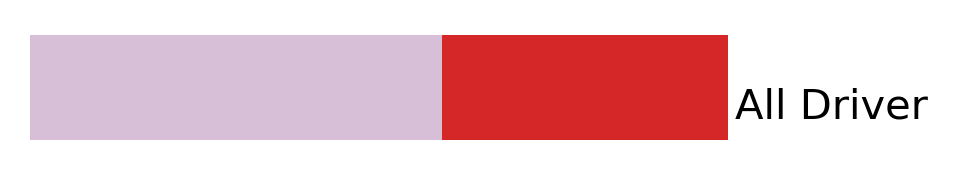

In [19]:
fig, ax = plt.subplots(figsize=(3,0.5), dpi=300)

driver = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1]
count_driver = len(driver[~driver['ID_mut'].isin(Observed_mut['ID_mut'].tolist())])
count_total = len(driver)
nonpredicted_frac = (count_total - count_driver) / count_total
predicted_frac = count_driver / count_total
print(predicted_frac)
ax.barh(0, nonpredicted_frac, height=0.3, color='thistle', left=0)
ax.barh(0, predicted_frac, height=0.3, left=nonpredicted_frac, color='tab:red')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0, 1)
ax.yaxis.set_label_position("right")
ax.set_ylabel('All Driver', rotation=0, labelpad=25)

### Mutational landscape by mutation

In [25]:
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
unique = set(non_HN_patients[(non_HN_patients['CH_driver_multiple']==0)]['patient'])
multiple = set(non_HN_patients[(non_HN_patients['CH_driver_multiple']==1)]['patient'])

In [28]:
# Mutational landscape by mutation
Mut_case = []
for gene in boostDM_predictions_nonHN['SYMBOL'].unique():
    freq = len(boostDM_predictions_nonHN_nonobs[boostDM_predictions_nonHN_nonobs['SYMBOL']==gene])
    freq_driv = len(boostDM_predictions_nonHN_nonobs[(boostDM_predictions_nonHN_nonobs['SYMBOL']==gene) & (boostDM_predictions_nonHN_nonobs['Drivers_12genes']==1)])
    freq_big = len(boostDM_predictions_nonHN_nonobs[(boostDM_predictions_nonHN_nonobs['SYMBOL']==gene) & (boostDM_predictions_nonHN_nonobs['Drivers_12genes']==1) &\
                                       (boostDM_predictions_nonHN_nonobs['VAF_alt']>=0.1)])
    freq_small = len(boostDM_predictions_nonHN_nonobs[(boostDM_predictions_nonHN_nonobs['SYMBOL']==gene) & (boostDM_predictions_nonHN_nonobs['Drivers_12genes']==1) &\
                                        (boostDM_predictions_nonHN_nonobs['VAF_alt']<0.1)])
    freq_pass = len(boostDM_predictions_nonHN_nonobs[(boostDM_predictions_nonHN_nonobs['SYMBOL']==gene) & (boostDM_predictions_nonHN_nonobs['Drivers_12genes']==0)])
    freq_driv_uniq = len(boostDM_predictions_nonHN_nonobs[(boostDM_predictions_nonHN_nonobs['SYMBOL']==gene) & (boostDM_predictions_nonHN_nonobs['Drivers_12genes']==1)&\
                                                  (boostDM_predictions_nonHN_nonobs['patient'].isin(unique))])
    freq_driv_mult = len(boostDM_predictions_nonHN_nonobs[(boostDM_predictions_nonHN_nonobs['SYMBOL']==gene) & (boostDM_predictions_nonHN_nonobs['Drivers_12genes']==1)&\
                                                  (boostDM_predictions_nonHN_nonobs['patient'].isin(multiple))])

#     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene, freq, freq_driv, freq_big, freq_small, freq_pass,freq_driv_uniq, freq_driv_mult])

In [29]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene', 'Cases', 'Drivers', 'Driver_big', 'Driver_small', 'Passangers', 'Driver_single', 'Driver_multiple']).sort_values('Cases', ascending=False)
Mut_case.reset_index()

,index,Gene,Cases,Drivers,Driver_big,Driver_small,Passangers,Driver_single,Driver_multiple
0,1,TET2,36929,6816,2026,4790,30113,5716,1100
1,3,ASXL1,33733,1300,104,1196,32433,1108,192
2,10,GNAS,19361,17,3,14,19344,15,2
3,2,DNMT3A,18536,5083,930,4153,13453,4384,699
4,6,PPM1D,12889,131,9,122,12758,113,18
5,7,CHEK2,9543,1396,922,474,8147,1212,184
6,4,SF3B1,9031,345,148,197,8686,284,61
7,5,TP53,7422,1333,326,1007,6089,1148,185
8,9,IDH2,7302,3,2,1,7299,0,3
9,8,MDM4,6530,62,20,42,6468,53,9


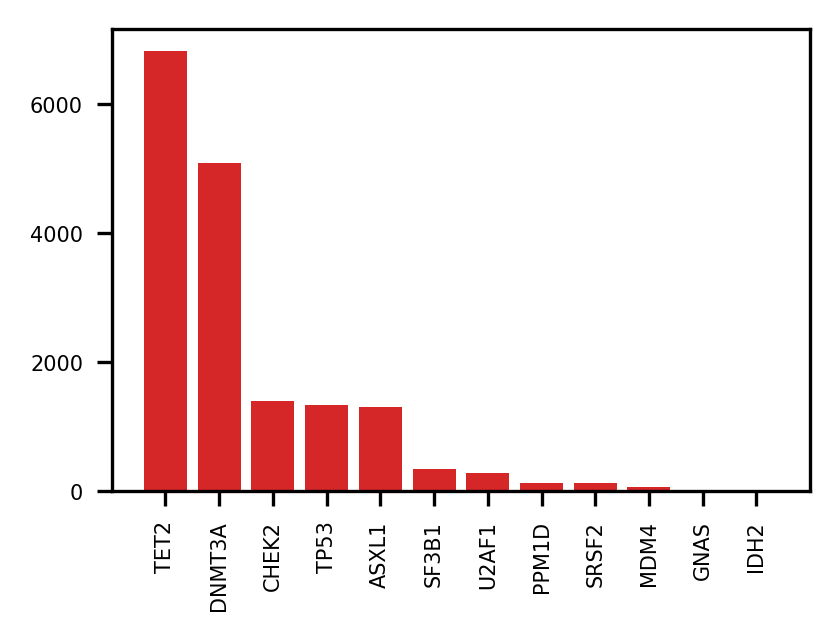

In [30]:
# importing package
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 2), dpi=300)
    
# create data
x = Mut_case.sort_values('Drivers', ascending=False)['Gene']
y2 = Mut_case.sort_values('Drivers', ascending=False)['Drivers']
 
# plot bars in stack manner
plt.bar(x, y2, color='tab:red')
plt.yticks(fontsize=5)
plt.xticks(rotation=90,fontsize=5)
plt.show()

## Include observed info to matrix

In [31]:
observed_patients = boostDM_predictions_nonHN[boostDM_predictions_nonHN['ID_mut'].isin(Observed_mut['ID_mut'].tolist())]['patient'].tolist()
ukb200K_ch_cancer_nonobs = ukb200K_ch_cancer[~ukb200K_ch_cancer['patient'].isin(observed_patients)]
len(ukb200K_ch_cancer_nonobs)

441682

In [32]:
ukb200K_ch_cancer_nonobs[ukb200K_ch_cancer_nonobs['num_CH_potential']==1]['CH_driver'].value_counts()

0    86152
1     9593
Name: CH_driver, dtype: int64

## 2- Age associations

### Age all togather

In [33]:
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_nonobs[ukb200K_ch_cancer_nonobs['var_HNALL_pre']==0]
len(ukb200K_ch_cancer_logistic)

439004

In [34]:
ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['num_CH_potential']==1]['CH_driver'].value_counts()

0    85643
1     9350
Name: CH_driver, dtype: int64

In [35]:
ukb200K_ch_cancer_logistic.groupby('age_group_x').size()

age_group_x
38-45     58136
46-50     60524
51-55     69900
56-60     85794
61-65    102493
66-72     62157
dtype: int64

In [36]:
age_groups = ['38-45', '46-50', '51-55', '56-60', '61-65', '66-72']; print(age_groups)
agegroups_all = [58136, 60524, 69900, 85794, 102493, 62157]; print(agegroups_all)
print(sum(agegroups_all))

### Get number of patients per age group
agegroups_all_group = ukb200K_ch_cancer_logistic.groupby('age_group_x').size()
agegroups_all_group

# CH by BosstDM-CH prediction

def prop_CH_model(data, model, normalize=False, printprop=False):
    agegroup_set = data[data[model] == 1].groupby('age_group_x').size()

    merged = pd.merge(agegroup_set.to_frame(), agegroups_all_group.to_frame(),left_index=True, right_index=True)
    prop_CH = round(merged.apply(lambda x: x['0_x'] / x['0_y'] * 100, axis=1), 4)
    
    if normalize == True:
        prop_CH = prop_CH.apply(lambda x: x / prop_CH[0])
    if printprop == True:
        print(prop_CH)
    return prop_CH


['38-45', '46-50', '51-55', '56-60', '61-65', '66-72']
[58136, 60524, 69900, 85794, 102493, 62157]
439004


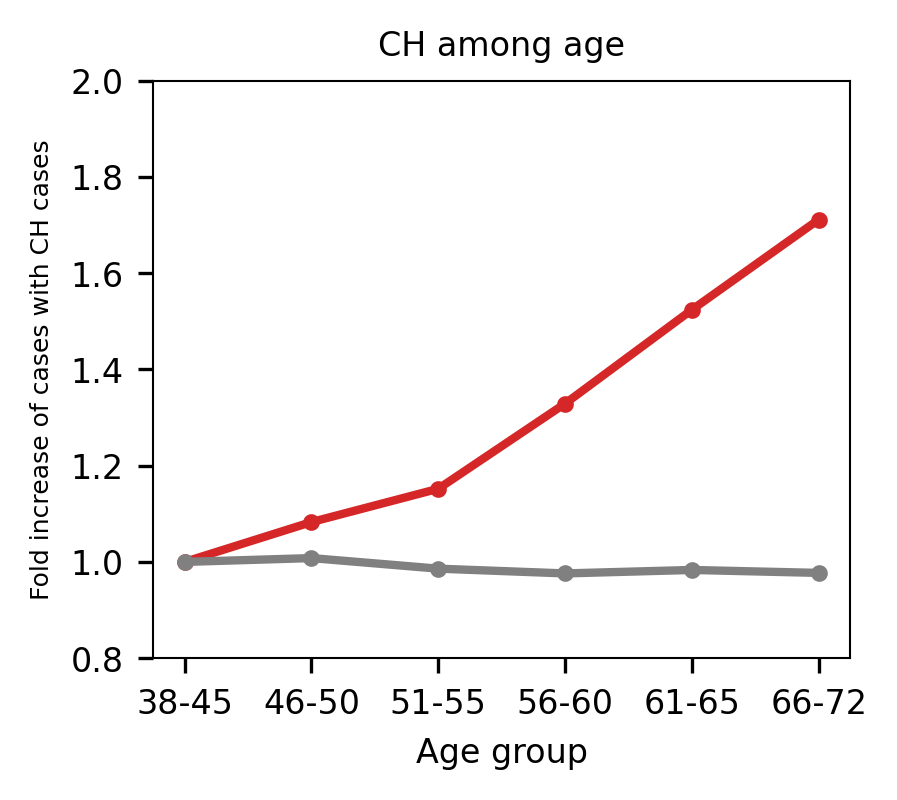

In [39]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3,2.5), dpi=300)

patient_age_ch_driver = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]
patient_age_ch_passengers = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_driver']==0]

agecorr_drivers = prop_CH_model(patient_age_ch_driver, 'CH_driver', normalize=True)
agecorr_pass = prop_CH_model(patient_age_ch_passengers, 'CH_nonDriver', normalize=True)

plt.plot(agecorr_drivers, '.-', linewidth=2, color='#D62728')
plt.plot(agecorr_pass, '.-', linewidth=2, color='grey')

plt.title('CH among age', fontsize = 8)
plt.xlabel('Age group',size=8)
plt.ylabel('Fold increase of cases with CH cases', fontsize=6)
plt.ylim([0.8,2])
plt.xticks(np.arange(6), age_groups, size=6)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

In [40]:
#Remove cases with prior hemathological
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer_nonobs[ukb200K_ch_cancer_nonobs['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
len(ukb200K_ch_cancer_logistic)

/tmp/jobs/jramis/9759392/ipykernel_10145/1265201215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ukb200K_ch_cancer_logistic.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)


439004

In [41]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc
    
#we have exclude pre hematological cases
CH_driver_multiple_matrix = ukb200K_ch_cancer_logistic[((ukb200K_ch_cancer_logistic['CH_nonDriver']==0) & (ukb200K_ch_cancer_logistic['CH_driver_multiple']==1)) | (ukb200K_ch_cancer_logistic['CH_potential'] == 0)]
CH_driver_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_nonDriver']==0]
CH_driver_big_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_small']==0]
CH_driver_small_matrix = CH_driver_matrix[CH_driver_matrix['CH_driver_big']==0]
CH_passengers_matrix = ukb200K_ch_cancer_logistic[ukb200K_ch_cancer_logistic['CH_driver']==0]


name = []
OR = []
cilow = []
ciup = []
pval = []
sig = []
    
#run model
for gene in ['CH_driver', 'CH_driver_multiple',  'CH_driver_big',  'CH_driver_small', 'CH_nonDriver', 'CH_potential']:
    if gene.endswith(('multiple')):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_multiple_matrix).fit()
    elif gene.endswith(('_driver')):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()
    elif gene.endswith('big'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_big_matrix).fit()
    elif gene.endswith('small'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_small_matrix).fit() 
    elif gene.endswith('nonDriver'):
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_passengers_matrix).fit()
    else:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=ukb200K_ch_cancer_logistic).fit()
    name.append(gene)
    OR.append(np.exp(model_hematopost.params[1]))
    cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
    ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
    pval.append(model_hematopost.pvalues[1])
    sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
varlist = pd.DataFrame(list(zip(name, OR, cilow, ciup, pval, sig)), columns = ['gene','OR', 'Lower CI', 'Upper CI', 'pval', 'sig'])
varlist["q_value"] = mtc.fdrcorrection(pd.to_numeric(varlist['pval']))[1]
varlist['sig'] = ['significant' if qval <= 0.05 else 'ns' for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.131150
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005676
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.048292
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100866
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.558677
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.584927
         Iterations 5


,gene,OR,Lower CI,Upper CI,pval,sig,q_value
0,CH_driver,1.023721,1.021037,1.026411,1.288460e-68,significant,7.730759e-68
1,CH_driver_multiple,1.043887,1.025457,1.062649,2.291284e-06,significant,2.749541e-06
2,CH_driver_big,1.028911,1.023864,1.033983,6.575667e-30,significant,1.315133e-29
3,CH_driver_small,1.021249,1.018093,1.024415,1.901541e-40,significant,5.704623e-40
4,CH_nonDriver,1.001012,1.000141,1.001883,2.277906e-02,significant,2.277906e-02
5,CH_potential,1.003391,1.002558,1.004224,1.367408e-15,significant,2.051113e-15


/tmp/jobs/jramis/9759392/ipykernel_10145/3980145984.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


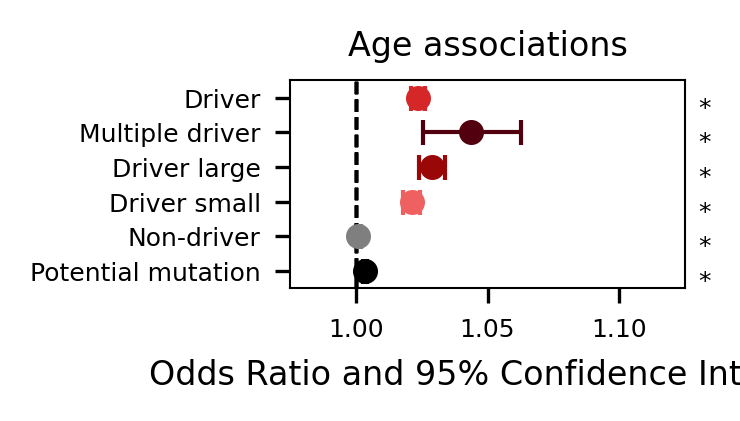

In [42]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.7, 0.9), dpi=300)
xlimit = 1.125
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if row['gene'].endswith('_driver'):
        plt.errorbar(x=[row['OR']], y=['Driver'], xerr=ci,
                 ecolor='#D62728', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#D62728", mec="#D62728")
    elif 'non' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Non-driver'], xerr=ci,
                 ecolor='tab:grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="tab:grey", mec="tab:grey")
    elif 'pot' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Potential mutation'], xerr=ci,
                 ecolor='k', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="k", mec="k")
    elif 'small' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver small'], xerr=ci,
                 ecolor='#EF6161', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EF6161", mec="#EF6161")
    elif 'big' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['Driver large'], xerr=ci,
                 ecolor='#990707', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#990707", mec="#990707")
    elif row['gene'].endswith('multiple'):
        plt.errorbar(x=[row['OR']], y=['Multiple driver'], xerr=ci,
                 ecolor='#52000F', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#52000F", mec="#52000F")
            
    if row['sig'] == 'significant':
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.005, ylimit-idx-0.5, '*', style='italic', fontsize=6)
    else:
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        ax.text(xlimit+0.005, ylimit-idx-0.5, 'ns', style='italic', fontsize=6)

        plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_title('Age associations', fontdict={'size':8})
plt.tight_layout()
plt.xlim([0.975, xlimit])
ax.set_ylim(-.5, ylimit+.5)
plt.yticks(fontsize=6)
plt.xticks([1, 1.05, 1.1], fontsize=6)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width

plt.show()